In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
import scipy as sp
from scipy.special import factorial
%matplotlib inline

## OO Version

In [2]:
class ModelSelection:
    def __init__(self, data):
        self.data = data
        self.n = len(data)
        self.datasum = data.sum()
        self.prod_factorial = factorial(data).prod()        
        
    def likelihood1(self, theta):
        return (pow(theta, self.data)/factorial(self.data)*np.exp(-theta)).prod()

    def prior1(self, theta):
        return np.exp(-theta)

    def likelihood2(self, theta):
        return (pow(theta, self.data)*(1-theta)).prod()

    def prior2(self, theta):
        assert theta > 0 and theta < 1
        return 1
    
    def draw_from_posterior1(self):
        return np.random.gamma(self.datasum+1, 1/(self.n+1))

    def draw_from_posterior2(self):
        N = len(data)
        return np.random.beta(self.datasum+1, self.n+1)
    
    def gamma_pdf(self, x, k, theta):
        return 1/(sp.special.gamma(k)*pow(theta, k))*pow(x, k-1)*np.exp(-x/theta)
    
    def MC_inv(self, N=10000):
        theta_list = np.array([self.draw_from_posterior1() for i in range(N)])
        res1 = 1/np.array([1/self.likelihood1(theta) for theta in theta_list]).mean()
        theta_list = np.array([self.draw_from_posterior2() for i in range(N)])
        res2 = 1/np.array([1/self.likelihood2(theta) for theta in theta_list]).mean()
        self.proba_MCinv = res1/(res2+res1)
        return res1, res2
        
    def __alpha1(self, x1, x2):
        return min(1, self.prior1(x2)*self.likelihood1(x2)/
                   self.prior1(x1)/self.likelihood1(x1))

    def __alpha2(self, x1, x2):
        return min(1, self.prior2(x2)*self.likelihood2(x2)/
                   self.prior2(x1)/self.likelihood2(x1))
    
    def __p1(self, x1, x2):
        return self.__alpha1(x1, x2)*self.gamma_pdf(x2, 1, 1)

    def __p2(self, x1, x2):
        return self.__alpha2(x1, x2)
    
    def MC_posterior(self, N1=1000):
        N2 = N1
        theta0 = 1    
        theta1_list = [self.draw_from_posterior1() for i in range(N1)]
        theta2_list = np.random.gamma(1, 1, N2)
        denominator = np.array([self.__p1(theta1, theta0) for theta1 in theta1_list]).mean()
        numerator = np.array([self.__alpha1(theta0, theta2) for theta2 in theta2_list]).mean()
        res1 = self.likelihood1(theta0)*self.prior1(theta0)*numerator/denominator
        
        theta0 = 0.5
        theta1_list = [self.draw_from_posterior2() for i in range(N1)]
        theta2_list = np.random.uniform(size=N2)
        denominator = np.array([self.__p2(theta1, theta0) for theta1 in theta1_list]).mean()
        numerator = np.array([self.__alpha2(theta0, theta2) for theta2 in theta2_list]).mean()
        res2 = self.likelihood2(theta0)*self.prior2(theta0)*numerator/denominator
        
        self.proba_MCposterior = res1/(res2+res1)

        return res1, res2

In [3]:
#data = np.random.poisson(1, 100)
data = np.random.geometric(0.5, 100)
data -= 1
PG = ModelSelection(data)

Sum: 108
prod(factorial): 58900016344872045772800000L


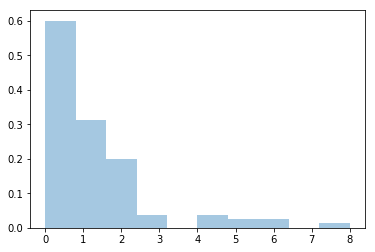

In [4]:
sns.distplot(data, kde=False, norm_hist=True)
print("Sum: %d" % PG.datasum)
print("prod(factorial): %dL" % PG.prod_factorial)

In [32]:
l1 = []
l2 = []
res = []
for i in range(1):
    res1, res2 = PG.MC_inv(1000000)
    l1.append(res1)
    l2.append(res2)
    res.append(PG.proba_MCinv)

/org/groups/chg/weili/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/org/groups/chg/weili/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


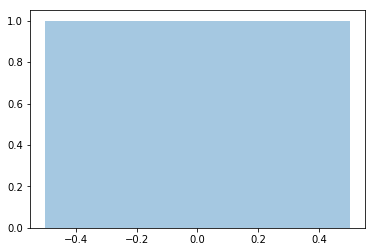

In [33]:
sns.distplot(res)

In [34]:
np.mean(l1) / np.mean(l2)

3.1099770053932312e-07

In [35]:
l3 = []
l4 = []
resPost = []
for i in range(1):
    res3, res4 = PG.MC_posterior(1000000)
    l3.append(res3)
    l4.append(res4)
    resPost.append(PG.proba_MCposterior)

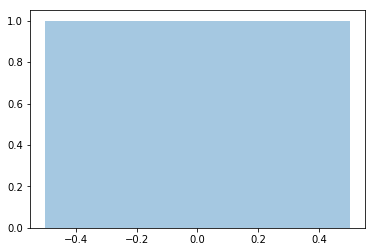

In [36]:
sns.distplot(resPost)

In [37]:
np.mean(l3) / np.mean(l4)

2.8996315883947932e-07

In [38]:
np.mean(resPost)

2.8996307476087023e-07

In [39]:
theta0 = 1
PG.likelihood1(theta0)*PG.prior1(theta0)

2.3234959106985134e-70

In [40]:
theta0 = 0.5
PG.likelihood2(theta0)*PG.prior2(theta0)

2.4308653429145085e-63